### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# TODO check torchtext version
if torchtext.__version__ == '0.8.1':
    from torchtext.data import Field, BucketIterator, TabularDataset
else:
    raise NotImplementedError

import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from train import *

In [5]:
import wandb
WANDB_GLOBAL = dict(
    entity='ermekaitygulov',
    group='Baseline',
    anonymous='allow',
    project='NLP-LAB2',
    reinit=True
)

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [6]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legac

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [10]:
SRC.build_vocab(train_data, min_freq = 5)
TRG.build_vocab(train_data, min_freq = 5)
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")


Unique tokens in source (ru) vocabulary: 5848
Unique tokens in target (en) vocabulary: 4254


Let's check the length distributions:

Length distribution in Test data


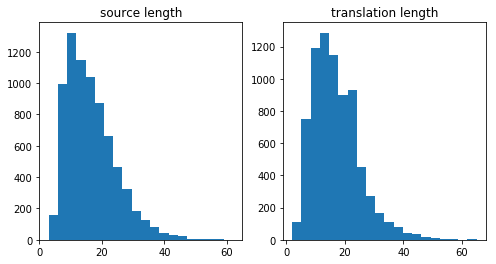

In [11]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [14]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [19]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 10
CLIP = 1

train_step = 0
val_step = 0
best_valid_loss = float('inf')
model_name = 'less_hd'
model_config = {}

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

name = f'{model_name}_{wandb.util.generate_id()}'
if wandb.run:
    wandb.finish()
wandb.init(name=name, config=model_config, **WANDB_GLOBAL)
wandb.watch(model, criterion, log_freq=100)

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,784,734 trainable parameters


In [21]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_step = train(
        model,
        train_iterator,
        optimizer,
        criterion,
        CLIP,
        train_step)

    valid_loss, val_step = evaluate(
        model,
        valid_iterator,
        criterion,
        val_step,
    )

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

  0%|          | 1/625 [00:00<01:20,  7.71it/s]

Epoch: 01 | Time: 0m 47s
	Train Loss: 5.091 | Train PPL: 162.607
	 Val. Loss: 5.194 |  Val. PPL: 180.128


  0%|          | 2/625 [00:00<00:51, 12.05it/s]

Epoch: 02 | Time: 0m 48s
	Train Loss: 4.190 | Train PPL:  65.993
	 Val. Loss: 5.100 |  Val. PPL: 163.973


  0%|          | 1/625 [00:00<01:12,  8.61it/s]

Epoch: 03 | Time: 0m 49s
	Train Loss: 3.823 | Train PPL:  45.741
	 Val. Loss: 4.894 |  Val. PPL: 133.489


  0%|          | 1/625 [00:00<01:09,  9.04it/s]

Epoch: 04 | Time: 0m 48s
	Train Loss: 3.564 | Train PPL:  35.319
	 Val. Loss: 4.791 |  Val. PPL: 120.364


  0%|          | 2/625 [00:00<00:54, 11.33it/s]

Epoch: 05 | Time: 0m 48s
	Train Loss: 3.397 | Train PPL:  29.882
	 Val. Loss: 4.715 |  Val. PPL: 111.643


  0%|          | 1/625 [00:00<01:10,  8.81it/s]

Epoch: 06 | Time: 0m 49s
	Train Loss: 3.261 | Train PPL:  26.065
	 Val. Loss: 4.589 |  Val. PPL:  98.371


  0%|          | 1/625 [00:00<01:12,  8.65it/s]

Epoch: 07 | Time: 0m 49s
	Train Loss: 3.165 | Train PPL:  23.690
	 Val. Loss: 4.524 |  Val. PPL:  92.220


  0%|          | 1/625 [00:00<01:08,  9.16it/s]

Epoch: 08 | Time: 0m 48s
	Train Loss: 3.079 | Train PPL:  21.741
	 Val. Loss: 4.615 |  Val. PPL: 101.032


  0%|          | 1/625 [00:00<01:08,  9.14it/s]

Epoch: 09 | Time: 0m 49s
	Train Loss: 2.997 | Train PPL:  20.030
	 Val. Loss: 4.510 |  Val. PPL:  90.928


100%|██████████| 40/40 [00:00<00:00, 57.14it/s, train_loss=5.04]

Epoch: 10 | Time: 0m 48s
	Train Loss: 2.931 | Train PPL:  18.753
	 Val. Loss: 4.483 |  Val. PPL:  88.457


In [22]:
test(model, test_iterator, TRG.vocab, train_step)
FINISH = True
if FINISH:
    wandb.finish()

118it [00:02, 56.76it/s]


train_loss,3.0559
train_step,6244
train_speed(batch/sec),12.5405
_step,660
_runtime,535
_timestamp,1620823632
val_loss,5.03875
val_step,399


train_loss,██▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▁▁
train_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_speed(batch/sec),█▅▇▇▇▅▅▇▄▅▅▅▆▆▆▁▅▅▆▄▅▄▅▄▃▅▄▄▆▄▆▅▆█▅▆▅▄▅█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▇█▇▆▇█▄▅▆█▄▅▆▇▃▄▅▇▂▃▅▇▂▃▄▇▂▃▅▇▁▃▅▇▁▃▄▇
val_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


__Let's take a look at our network quality__:

In [24]:
from utils import generate_translation


In [26]:
batch = next(iter(test_iterator))
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: all rooms come with a tv .
Generated: each room is fitted with a tv .

Original: there is a 24 - hour front desk at the property .
Generated: a 24 - hour front desk .



Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points